In [ ]:
#for google drive only
from google.colab import drive
drive.mount('/content/drive')
%cd ../content/drive/My\ Drive/Code/HaikuBot/notebooks/

# import nltk
# nltk.download('punkt')

Mounted at /content/drive
/content/drive/My Drive/Code/HaikuBot/notebooks


In [ ]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
import utils
from utils.haiku_scrape import scrape_haiku, replace_all, detokenize

import matplotlib.pyplot as plt
import numpy as np
from pickle import dump, load

#TF,nltk, scikit
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
#from nltk import word_tokenize

# Word level Haiku bot

Training an LSTM network on word n-grams (n=3 for now).

# TODO
- Look at performance measures other than accuracy as that might not be the goal of this model

### Several approaches to enforce syllable rule:
1. Let the RNN learn on its own and see if it figures it out automatically 
    - Though syllables as a latent variable has very little hints in written text, this might work better with audio data of haikus
2. Restrict number of output units for each stanza as the max number of words/stanza from the data 
    - Then in output, iterate until syllable count satisfied `(while count_syl(stanza) != 5...`
        - This might not be so computationally expensive depending on number of possibile syllables (check this)      
3. Break data down into phoneme/syllable components and feed that through RNN

### Data cleaning
- Some post titles have a preface, amend this by taking all text after a colon?
- `["we", "'ve"]` detokenizes differently than `["do", "n't"]`
- encoder doesn't like single quote quotes `'ex'`
 
### Embeddings
- transfer learning compare pre trained vs trained 
    - maybe find a poem embedding
- vis with umap

### Architectures 
- consider the bidirectional

# Resources
- [Medium](https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d)
- [Jason word based 1](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/)
- [Jason word based 2](https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/)
- [import embeddings](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
- [return seq](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)
- [Visualize Embeddings](https://blog.dataiku.com/deep-beers-visualizing-embeddings-of-keras-recommendation-engines)

In [ ]:
def load_haiku(in_dir='../data/lines.txt'):
  with open(in_dir, 'r') as f:
    haikus = f.read()
  return haikus.split('\n')

h_set = load_haiku()

In [ ]:
h_set = h_set[:int(len(h_set)*0.6)]

In [ ]:
def prepare_data(haikus,n=3):
    """n: n-gram size"""
    train = [] #n_grams
    token_vocab = []
    for h in haikus:
        tokens = h.split() #word_tokenize(h)
        token_vocab.extend(tokens)
        for i in range(0,len(tokens)):
            n_gram_list = tokens[i:i+n]
            if len(n_gram_list) == n:
                train.append(detokenize(n_gram_list))
            else:
                break
    return train, token_vocab
train, token_vocab = prepare_data(h_set)

In [ ]:
### With tf tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train)
# sequences = tokenizer.texts_to_sequences(train)
# sequences = [i for i in sequences if len(i) == 3] # removing entries with apostrophe for now

# custom tokenizer doesn't skip non letter words
token_vocab = sorted(list(set(token_vocab)))
vocab_size = len(token_vocab) # len(tokenizer.word_index) + 1
print('total # tokens:', vocab_size)
token_indices = {t: i for i, t in enumerate(token_vocab)}
indices_token = {i: t for i, t in enumerate(token_vocab)}

# or

def encode_seq(seq, mapping):
    sequences = []
    for ix, line in enumerate(seq):
        # integer encode line
        try:
            encoded_seq = [mapping[t] for t in line.split()]
            sequences.append(encoded_seq)
        except:
#             print(ix, line)
            pass
    return np.array(sequences)

# encode the sequences
sequences = encode_seq(train, token_indices)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
seq_length = X_train.shape[1]

total # tokens: 11009


# Model

Sequential LSTM

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=seq_length),
    LSTM(100,return_sequences=True), #, recurrent_regularizer=l2(0.01)
    # Dropout(0.2),
    LSTM(100),
    # Dropout(0.2),
    Dense(100,activation = 'relu'),
    Dense(200,activation = 'relu'),
    Dense(vocab_size, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 50)             550450    
_________________________________________________________________
lstm (LSTM)                  (None, 2, 100)            60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 11009)             2212809   
Total params: 2,934,359
Trainable params: 2,934,359
Non-trainable params: 0
______________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=100)
save = 1
if save:
    model.save('../models/model.h5')
    #dump(tokenizer, open('../models/tokenizer.pkl', 'wb'))

Epoch 1/100
645/645 [==============================] - 28s 31ms/step - loss: 6.5250 - accuracy: 0.1463 - val_loss: 6.2527 - val_accuracy: 0.1459
Epoch 2/100
645/645 [==============================] - 18s 28ms/step - loss: 6.0658 - accuracy: 0.1486 - val_loss: 6.1818 - val_accuracy: 0.1563
Epoch 3/100
645/645 [==============================] - 16s 24ms/step - loss: 5.8405 - accuracy: 0.1635 - val_loss: 6.1290 - val_accuracy: 0.1632
Epoch 4/100
645/645 [==============================] - 16s 24ms/step - loss: 5.6677 - accuracy: 0.1658 - val_loss: 6.1368 - val_accuracy: 0.1650
Epoch 5/100
645/645 [==============================] - 17s 27ms/step - loss: 5.4943 - accuracy: 0.1733 - val_loss: 6.1924 - val_accuracy: 0.1706
Epoch 6/100
645/645 [==============================] - 16s 24ms/step - loss: 5.3178 - accuracy: 0.1823 - val_loss: 6.2601 - val_accuracy: 0.1686
Epoch 7/100
645/645 [==============================] - 16s 24ms/step - loss: 5.1573 - accuracy: 0.1939 - val_loss: 6.3479 - val_ac

In [ ]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print(acc)

0.13874031603336334


Text(0.5, 1.0, 'Max val accuracy 0.17')

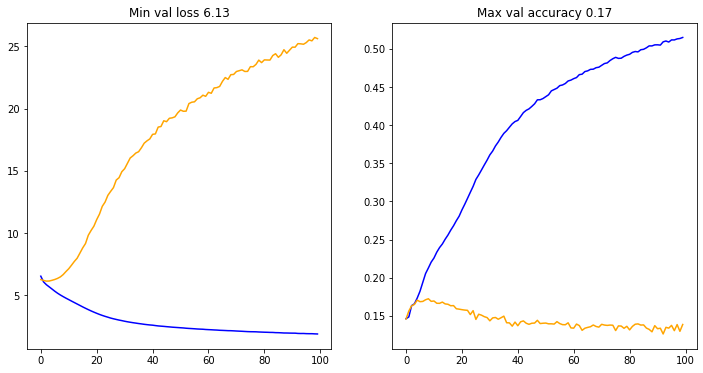

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test'); plt.title(f'Min val loss {min(history.history["val_loss"]):.2f}')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test'); plt.title(f'Max val accuracy {max(history.history["val_accuracy"]):.2f}')

# Text generation

In [ ]:
model = load_model('../models/model.h5',compile=False)
tokenizer = load(open('../models/tokenizer.pkl', 'rb'))

In [ ]:
#index_word = {v:k for k,v in tokenizer.word_index.items()}
def generate_seq(model, seq_length, seed_text, n_words,tokenizer=encode_seq):
    output = []
    text = seed_text
    for _ in range(n_words):
        #encoded = tokenizer.texts_to_sequences([text])[0] # encode the text as integer
        encoded = encode_seq([text], token_indices)[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre') #truncate sequences toa  fixed length (since reinputted)
        yhat = np.argmax(model.predict(encoded), axis=-1) #model.predict_classes(encoded, verbose=False)
        #print(yhat)
        _word = indices_token[yhat[0]] # map predicted word index to word
        if _word == '$':
          return ' '.join(output)
        text += ' ' + _word
        output.append(_word)
        
seq_length = len(train[0].split()) - 1 # also defined as X.shape[1] above
seed_text = train[np.random.randint(0,len(train))]
seed_text = "i am not"
print(seed_text + '\n')
generated = generate_seq(model, seq_length, seed_text, 20,tokenizer=None)
print(generated)

i am not

ready / capturing reality / probabilities


In [ ]:
for h in h_set:
  if 'capturing reality' in h:
    print(h)
    

camera ready / capturing reality / photography fun $


# T-SNE embedding visualization

Mostly continuous - interpretation to be taken with grain of salt. Maybe due to the abstract semantics in most of the haikus.

In [ ]:
weights = model.get_weights()
embedding = weights[0]

In [ ]:
from sklearn.manifold import TSNE
item_tsne = TSNE(perplexity=30).fit_transform(embedding)

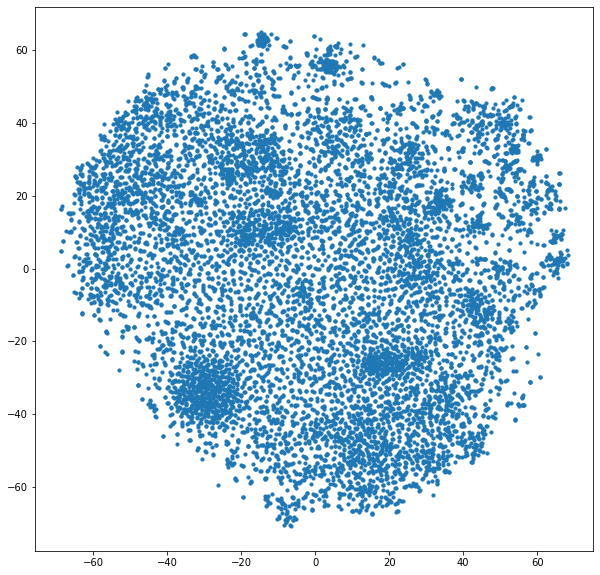

In [ ]:
plt.figure(figsize=(10,10))
sc = plt.scatter(item_tsne[:,0], item_tsne[:,1],s=10)